In [1]:
import os
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict, get_dataset_split_names
import matplotlib.pyplot as plt

In [2]:
#Environment
load_dotenv(override=True)

#Get the HF token from environment variables
hf_token = os.getenv('HF_TOKEN')

#Log in to Hugging face
login(hf_token,add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
rawdata = load_dataset("cogsci13/Amazon-Reviews-2023-Books-Review", split="full", trust_remote_code = True)

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'cogsci13/Amazon-Reviews-2023-Books-Review' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Resolving data files:   0%|          | 0/33 [00:00<?, ?it/s]

Loading dataset shards:   0%|          | 0/33 [00:00<?, ?it/s]

In [4]:
len(rawdata)

29475453

In [5]:
rawdata[0]

{'rating': 1.0,
 'title': 'Not a watercolor book! Seems like copies imo.',
 'text': 'It is definitely not a watercolor book.  The paper bucked completely.  The pages honestly appear to be photo copies of other pictures. I say that bc if you look at the seal pics you can see the tell tale line at the bottom of the page.  As someone who has made many photocopies of pages in my time so I could try out different colors & mediums that black line is a dead giveaway to me. It’s on other pages too.  The entire book just seems off. Nothing is sharp & clear. There is what looks like toner dust on all the pages making them look muddy.  There are no sharp lines & there is no clear definition.  At least there isn’t in my copy.  And the Coloring Book for Adult on the bottom of the front cover annoys me. Why is it singular & not plural?  They usually say coloring book for kids or coloring book for kids & adults or coloring book for adults- plural.  Lol  Plus it would work for kids if you can get over

In [6]:
filtered = (
    dp for dp in rawdata
    if "rating" in dp and dp["rating"] is not None
    and "text" in dp and isinstance(dp["text"], str) and dp["text"].strip() != ""
    and "title" in dp and isinstance(dp["title"], str) and dp["title"].strip() != ""
)

In [7]:
sampled_data = []
for i, dp in enumerate(filtered):
    if i >= 500000:
        break
    sampled_data.append(dp)

dataset = Dataset.from_list(sampled_data)
print(f"Loaded {len(dataset):,}")

Loaded 500,000


In [8]:
# empty_column = [None] * len(dataset)
# dataset = dataset.add_column("sentiment", empty_column)
# def assign_sentiment(example):
#     if example["rating"] >= 4 :
#         example["sentiment"] = "Positive"
#     else:
#         example["sentiment"] = "Negative"
#     return example

# dataset = dataset.map(assign_sentiment)

In [9]:
from BookItems import BookItems

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [10]:
book_items = []
for data in dataset:
    try: 
        book_item = BookItems(data)
        book_item.MakePrompt()
        book_items.append(book_item)
    except (ValueError,TypeError):
        pass


In [11]:
print(type(book_items[1].prompt))

<class 'NoneType'>


In [12]:
len(book_items)

500000

In [13]:
Books = []
for i in range(len(book_items)):
    if isinstance(book_items[i].prompt,str):
        Books.append(book_items[i])
    else: 
        pass


In [14]:
print(len(Books))

146578


In [15]:
print(Books[19999].test_prompt())

Analyze the following product review and provide both the rating and a short summary.

Review:
I want you to write about me having AIDS because I don't want anyone else to suffer in silence like we have. ~Nancy's Mom<br /><br />When Nancy A. Draper's mother underwent a bypass surgery, she received a transfusion that turned out to be HIV contaminated blood. At the age of 66 she was diagnosed with AIDS and battled with her illness until she was 69. Before Nancy's mother died, she asked


Output:



In [16]:
for book in Books:
    if book.rating == 0:
        print(1)

1
1


In [18]:
import numpy as np

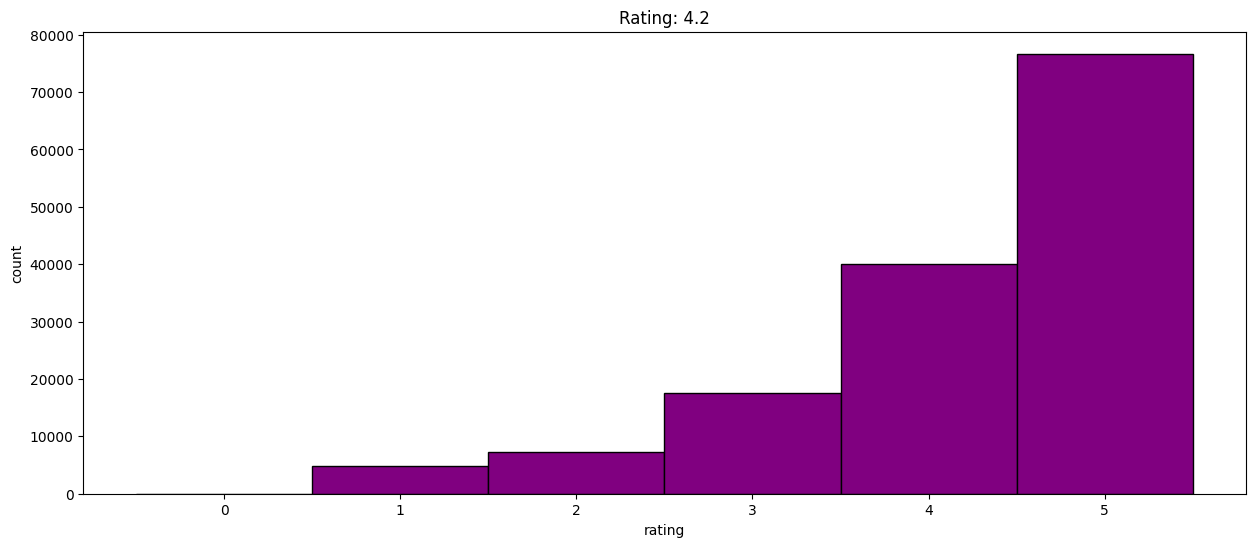

In [19]:
rating = [book.rating for book in Books]
plt.figure(figsize=(15,6))
plt.title(f"Rating: {sum(rating)/len(rating):,.1f}")
plt.xlabel('rating')
plt.ylabel('count')
plt.hist(rating, color="purple", bins=np.arange(-0.5, 6.5, 1), edgecolor='black')
plt.show()


In [20]:
from collections import defaultdict
import numpy as np
import random


In [21]:
rating_buckets = defaultdict(list)
for book in Books:
    rating = book.rating
    rating_buckets[rating].append(book)

np.random.seed(146)
random.seed(146)

sample = []
for rating in range(0,6):
    bucket = rating_buckets[rating]
    if rating < 3:
        sample.extend(bucket)
    elif len(bucket) <= 4000:
        sample.extend(bucket)
    else:
        selected_indices = np.random.choice(len(bucket),size = 6000, replace = False)
        selected = [bucket[i] for i in selected_indices]
        sample.extend(selected)
    
     

In [22]:
len(sample)

30191

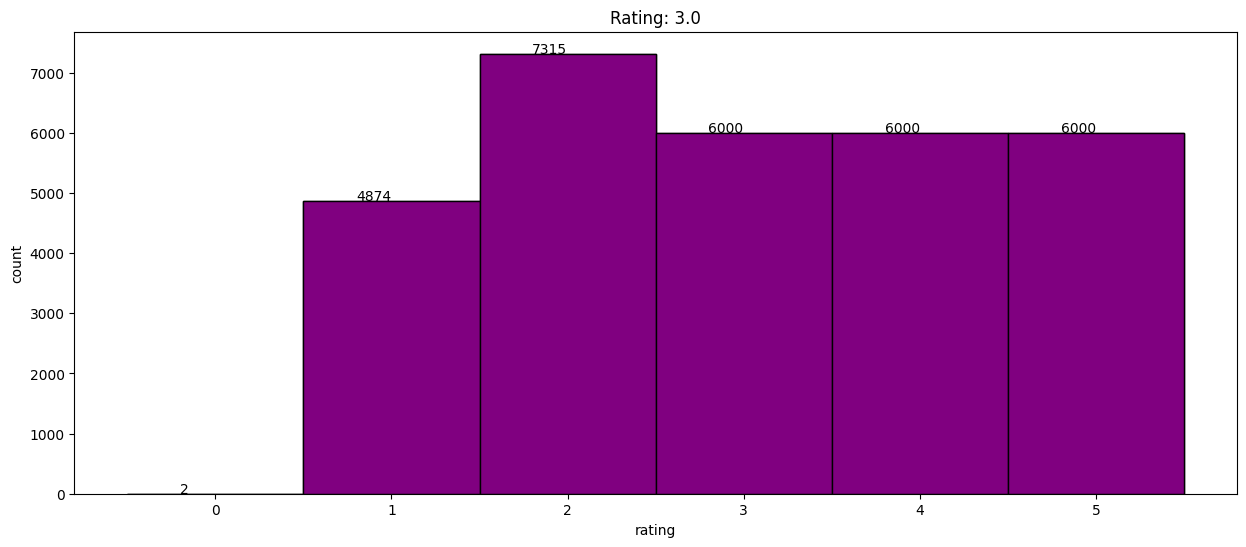

In [23]:
rating = [item.rating for item in sample]
plt.figure(figsize=(15,6))
plt.title(f"Rating: {sum(rating)/len(rating):,.1f}")
plt.xlabel('rating')
plt.ylabel('count')
plt.hist(rating, color="purple", bins=np.arange(-0.5, 6.5, 1), edgecolor='black')
counts, bins, patches = plt.hist(rating, bins=np.arange(-0.5, 6.5, 1), color="purple", edgecolor='black')
for i in range(len(counts)):
    plt.text(bins[i] + 0.3, counts[i] + 5, int(counts[i]), color='black')

plt.show()

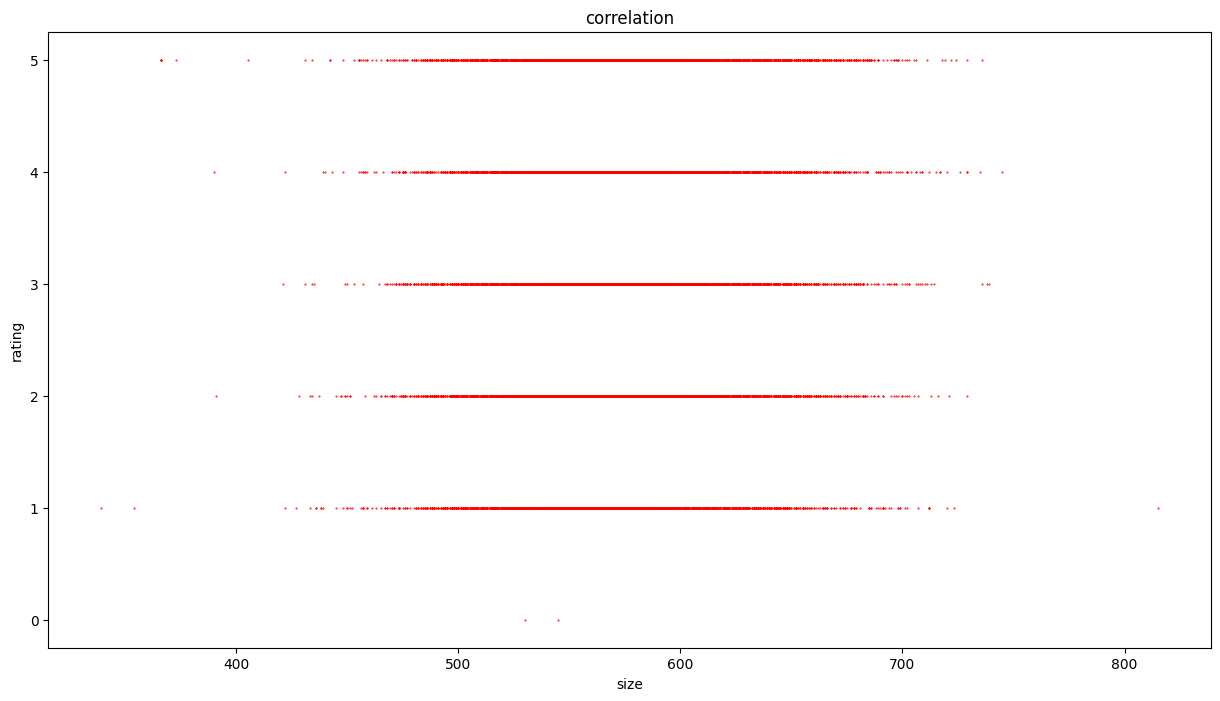

In [24]:
sizes = [len(item.prompt) for item in sample]
rating = [item.rating for item in sample]

plt.figure(figsize=(15,8))
plt.scatter(sizes,rating,s = 0.2, color= "red")

plt.xlabel('size')
plt.ylabel('rating')
plt.title('correlation')
plt.show()

In [25]:
random.seed(123)

random.shuffle(sample)
split_idx = int(0.8* len(sample))

train = sample[:split_idx]
test = sample[split_idx:]
print(f"Divide into training set of 80% sample: {len(train)} and test set of 20% sample: {len(test)}")

Divide into training set of 80% sample: 24152 and test set of 20% sample: 6039


In [31]:
# Upload to hugging face   
train_prompts = [item.prompt for item in train]
test_prompts = [item.test_prompt() for item in test]

train_dataset = Dataset.from_dict({"text": train_prompts})
test_dataset = Dataset.from_dict({"text":test_prompts})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [ ]:
from huggingface_hub import login
import os
os.environ.pop("HF_TOKEN", None)
hf_token_write = os.getenv('HF_TOKEN_WRITE')
login(hf_token_write,add_to_git_credential=True)

In [44]:
HF_USER = "Hoangee2"
DATASET_NAME = f"{HF_USER}/ratingbook_data"
dataset.push_to_hub(DATASET_NAME, private=True)

HfHubHTTPError: (Request ID: Root=1-690f48b2-73f15fcb43e336144e9c9410;29eaf87c-cead-47cd-a34a-4245cf30b3ff)

403 Forbidden: You don't have the rights to create a dataset under the namespace "Hoangee2".
Cannot access content at: https://huggingface.co/api/repos/create.
Make sure your token has the correct permissions.

In [35]:
import pickle

with open('train.pkl','wb') as file:
    pickle.dump(train,file)

with open('test.pkl','wb') as file:
    pickle.dump(test,file)

In [1]:
import pickle

with open('train.pkl','rb') as file:
    train = pickle.load(file)

with open('test.pkl','rb') as file:
    test = pickle.load(file)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [2]:
from datasets import  Dataset, DatasetDict
train_prompts = [item.prompt for item in train]
test_prompts = [item.test_prompt() for item in test]

train_dataset = Dataset.from_dict({"text": train_prompts})
test_dataset = Dataset.from_dict({"text":test_prompts})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [6]:
import os
os.environ.pop("HF_TOKEN", None)

from huggingface_hub import login
hf_token_write = os.getenv('HF_TOKEN_WRITE')
login(hf_token_write,add_to_git_credential=True)

In [7]:
HF_USER = "Hoangee2"
DATASET_NAME = f"{HF_USER}/ratingbook-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/1 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

CommitInfo(commit_url='https://huggingface.co/datasets/Hoangee2/ratingbook-data/commit/a40f4c7dc5a4cfda396a7f553f4d271b194dfa40', commit_message='Upload dataset', commit_description='', oid='a40f4c7dc5a4cfda396a7f553f4d271b194dfa40', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/Hoangee2/ratingbook-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='Hoangee2/ratingbook-data'), pr_revision=None, pr_num=None)